In [2]:
from scipy.io import savemat
import scipy.io     # used to load .mat data

import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tqdm
import seaborn as sns

from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN
from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN, cVAE_Full, cVAE_hybrid, cVAE_tandem
from utils import evaluate_simple_inverse, evaluate_tandem_accuracy, evaluate_vae_inverse, evaluate_vae_minmax_inverse,evaluate_vae_minmax_GSNN_inverse, evaluate_gan_inverse, evaluate_inn_inverse
from utils import evaluate_tandem_minmax_accuracy, evaluate_minmax_forward, evaluate_tandem_minmax_newforward_accuracy
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('tandem_net')

forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained_training_old.pth')['model_state_dict'])



<All keys matched successfully>

In [3]:
def evaluate_forward(forward_model, dataset):
    # for evaluate the dataset itself.
    '''
    The dataset need to be in inverse format, i.e., x corresponds to target while y corresponds to design.
    '''
    forward_model.eval()
    with torch.no_grad():
        range_, min_ = torch.tensor(dataset.scaler.data_range_).to(DEVICE), torch.tensor(dataset.scaler.data_min_).to(DEVICE)
        x, y = dataset.x.to(DEVICE), dataset.y.to(DEVICE)
        x_dim = x.size()[1]
        M = x.size()[0]
        x_pred = forward_model(y, x)
        x_pred_raw = x_pred *range_[:x_dim] + min_[:x_dim]
        x_raw = x *range_[:x_dim] + min_[:x_dim]
        
    x_pred_raw = x_pred_raw.cpu().numpy()
    x_raw = x_raw.cpu().numpy()
    return  x_pred_raw, x_raw


def struc_check(structure):
    if np.sum(abs(structure)-structure)>0:  # if get negative parameters, then wrong structure
        return 0
    else:
        struc = np.reshape(structure, (-1, 4));
        N = np.shape(struc)[0]
        #print(struc)
        for i in range(N):
            if (struc[i,1]+struc[i,3]>=struc[i,2]):  # if gap+diameter >= period, then wrong structure
                return 0;
            
        return 1;

def struc_remove_1(param_pred):
    M = np.shape(param_pred)[0]
    B = []
    print(M)
    for i in range(M):
        if struc_check(param_pred[i,:])==0:
            B.append(i)
            print(i)
    
    return B

    
def plt_hist_all(param, labels):
    plt.figure(figsize = [20, 3])
    plt.subplot(1, 4,1)
    plt.hist(param[:,0], bins=20, histtype='step', label=labels)
    plt.title('Height histogram')
    plt.xlabel('Height/(nm)')
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 4,2)
    plt.hist(param[:,1], bins=20, histtype='step', label=labels)
    plt.title('Gap histogram')
    plt.xlabel('Gap/(nm)')
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 4, 3)
    plt.hist(param[:,2], bins=20, histtype='step', label=labels)
    plt.title('Period histogram')
    plt.xlabel('Period/(nm)')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.hist(param[:,3], bins=20, histtype='step', label=labels)
    plt.title('Diameter histogram')
    plt.xlabel('Diamater/(nm)')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    
def plt_abs_err(CIE_x, cie_pred):
    abs_err = abs(CIE_x - cie_pred)
    abs_mean = sum(abs_err)/len(abs_err)
    
    plt.figure(figsize = [8, 7])
    plt.subplot(3,1 ,1)
    plt.scatter(CIE_x[:,0],abs_err[:,0], color='r',label='x')
    plt.axhline(y=abs_mean[0],color='r', linestyle='-')
    plt.text(0.5,abs_mean[0] , str(round(abs_mean[0],4)), bbox=dict(facecolor='w', alpha=0.5))
    plt.ylabel('Abs error')
    plt.legend()
    
    plt.subplot(3,1,2)
    plt.scatter(CIE_x[:,1],abs_err[:,1], color='g',label='y')
    plt.axhline(y=abs_mean[1], color='g',linestyle='-')
    plt.text(0.6,abs_mean[1] , str(round(abs_mean[1],4)), bbox=dict(facecolor='w', alpha=0.5))
    plt.ylabel('Abs error')
    plt.legend()
    
    plt.subplot(3,1, 3)
    plt.scatter(CIE_x[:,2],abs_err[:,2], color='b',label='Y')
    plt.axhline(y=abs_mean[2], color='b',linestyle='-')
    plt.text(0.6,abs_mean[2] , str(round(abs_mean[2],4)), bbox=dict(facecolor='w', alpha=0.5))
    plt.ylabel('Abs error')
    plt.legend()

def struc_remove_2(param_pred):
    # remove the structure that is not inside the parameter range space. 
    M = np.shape(param_pred)[0]
    B = []
    print(M)
    for i in range(M):
        if (param_pred[i,3]>=160)|(param_pred[i,3]<=80)|(param_pred[i,0]>=200)|(param_pred[i,0]<=30)|(param_pred[i,1]>=320)|(param_pred[i,1]<=160)|(param_pred[i,2]>=700)|(param_pred[i,2]<=30):
            B.append(i)
            #print(i)
    
    return B


print('Okay')

Okay


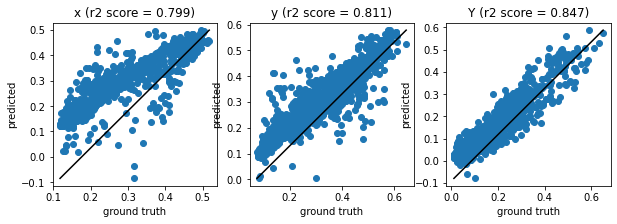

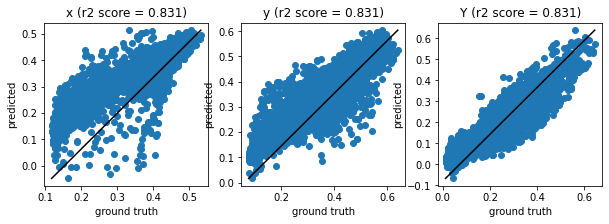

In [3]:
## check the forward used in vae

configs = get_configs('vae_Full')
vae_model = cVAE_Full(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_Full_trained_5.pth')['model_state_dict'])

forward_model = MLP(4, 3).to(DEVICE)

configs = get_configs('vae_hybrid')
vae_model = cVAE_Full(configs['input_dim'], configs['latent_dim']).to(DEVICE)

vae_model = cVAE_hybrid(forward_model, vae_model)

vae_model.load_state_dict(torch.load('./models/vae_hybrid_trained_5_no_pretrained.pth')['model_state_dict'])

forward_model = vae_model.forward_model

cie_pred, cie_raw = evaluate_forward(forward_model, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


cie_pred, cie_raw = evaluate_forward(forward_model, train_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


# Plot forward model

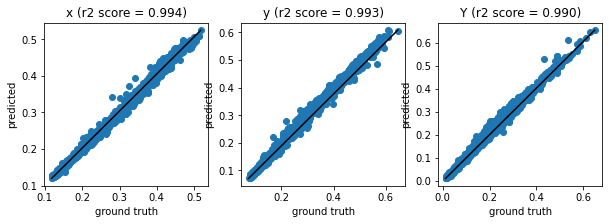

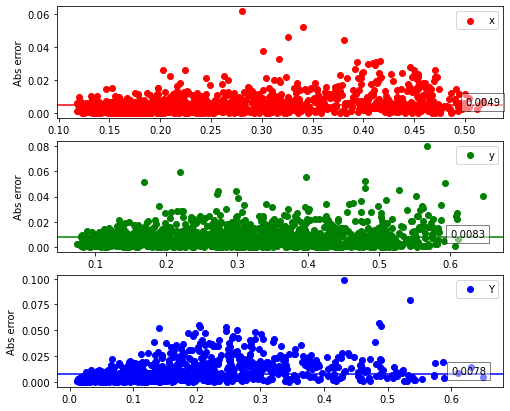

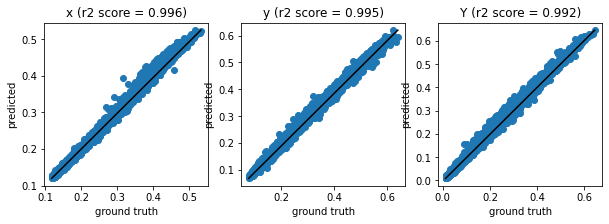

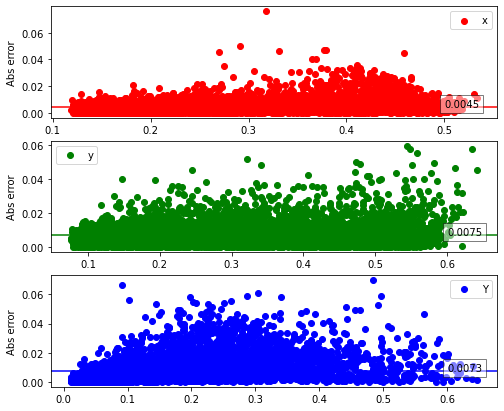

In [35]:
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained_evaluate_2.pth')['model_state_dict'])


cie_pred, cie_raw = evaluate_forward(forward_model, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

# Plot Absolute Error
# target - forward 
plt_abs_err(cie_raw, cie_pred)

cie_pred, cie_raw = evaluate_forward(forward_model, train_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

# Plot Absolute Error
# target - forward 
plt_abs_err(cie_raw, cie_pred)

# Tandem

Tandem net Design RMSE loss 0.763
Tandem Design RMSE loss 176.034
Reconstruct RMSE loss 0.035
Reconstruct RMSE loss raw 0.019


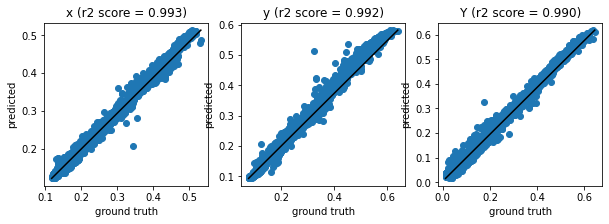

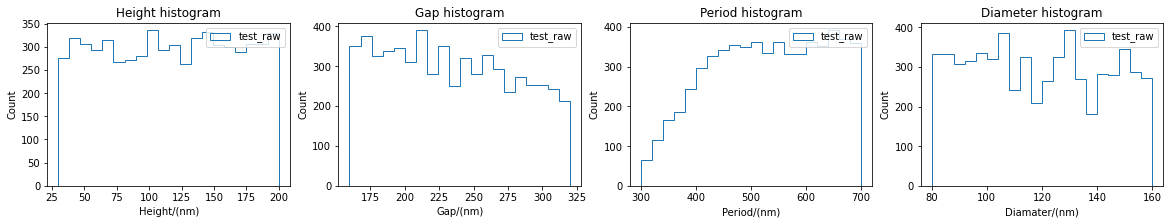

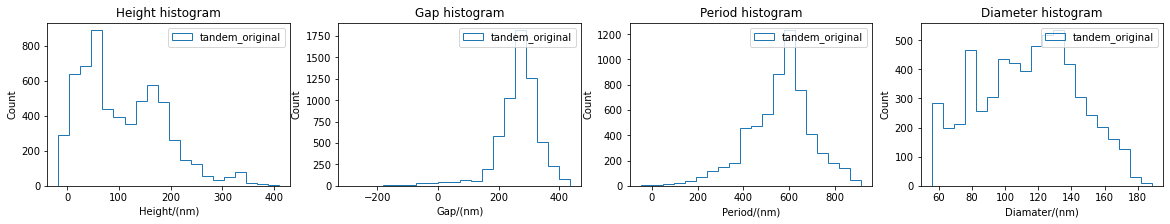

Tandem net Design RMSE loss 0.753
Tandem Design RMSE loss 171.554
Reconstruct RMSE loss 0.036
Reconstruct RMSE loss raw 0.020


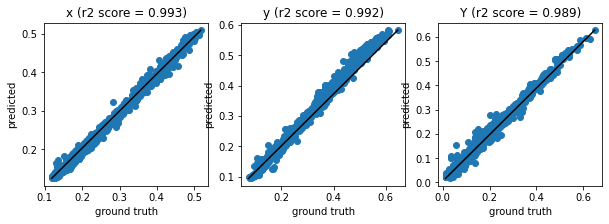

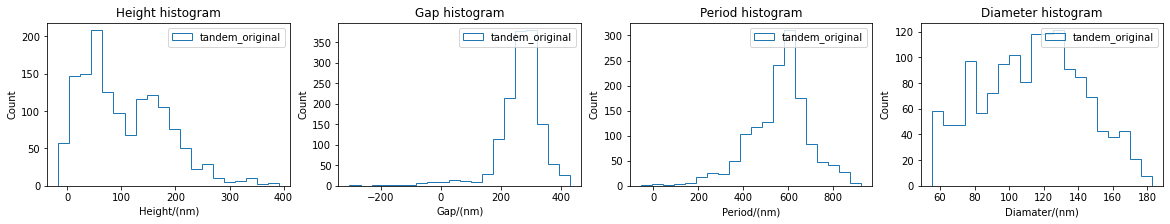

In [44]:
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained_training.pth')['model_state_dict'])
inverse_model = MLP(3, 4).to(DEVICE)

# on train dataset
tandem_model = TandemNet(forward_model, inverse_model)
tandem_model.load_state_dict(torch.load('./models/tandem_net_trained.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_minmax_accuracy(tandem_model, train_loader.dataset)

plot_cie_raw_pred(cie_raw, cie_pred)
plt_hist_all(param_raw,'test_raw')

plt_hist_all(param_pred,'tandem_original')

# on test dataset
cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_minmax_accuracy(tandem_model, test_loader.dataset)

plot_cie_raw_pred(cie_raw, cie_pred)
plt_hist_all(param_pred,'tandem_original')

In [45]:
# Save the data 

mdic = {"param_pred_all": param_pred,"cie_pre_all":cie_pred,"param_test_all": param_raw,"CIE_x_all": cie_raw}
savemat("data_predicted\param_tandem_pred_all.mat",mdic)

B = struc_remove_1(param_pred)

cie_pred = np.delete(cie_pred, B, 0)
cie_raw = np.delete(cie_raw, B, 0)
param_pred = np.delete(param_pred, B, 0)
param_raw = np.delete(param_raw, B, 0)

mdic = {"param_pred": param_pred,"param_test": param_raw,"cie_pred": cie_pred, "CIE_x": cie_raw, "deleted_row":B}
savemat("data_predicted\param_tandem_pred.mat",mdic)
np.shape(param_pred)

1411
33
34
41
69
75
77
90
96
97
107
108
122
123
141
145
154
161
172
182
198
201
203
206
208
217
223
225
229
237
238
247
251
253
267
274
298
303
327
330
334
337
381
399
416
419
428
431
435
438
494
498
500
502
504
513
528
540
546
566
572
582
590
605
607
608
609
614
621
637
641
650
654
656
696
721
744
753
754
762
768
771
781
787
834
839
848
849
853
859
860
873
879
892
933
938
944
947
956
963
970
985
986
1004
1006
1009
1013
1036
1050
1059
1061
1062
1068
1074
1077
1079
1097
1107
1108
1143
1151
1158
1162
1167
1170
1198
1205
1219
1222
1229
1236
1259
1273
1274
1290
1302
1304
1320
1327
1336
1364
1368
1372
1382
1406
1408


(1266, 4)

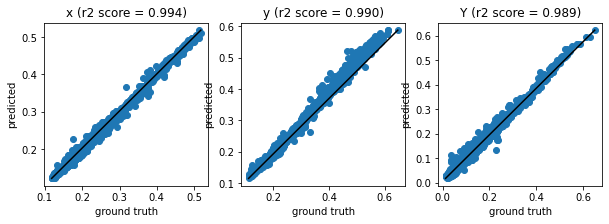

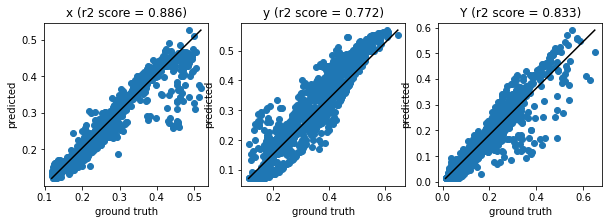

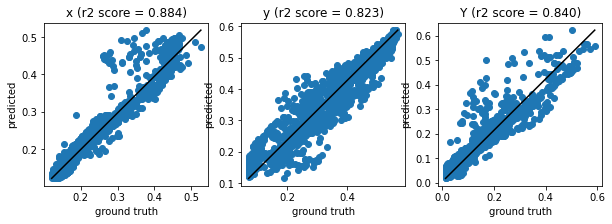

In [18]:
# Plot the result(only delete structures that not satisfy the limitation of structures)

filepath ="data_predicted/xyY/xyY_param_tandem_pred.mat"
filepath3 = "data_predicted/param_tandem_pred.mat"

temp = scipy.io.loadmat(filepath)
xyY_pred = np.array(list(temp.items())[7][1])  # predicted by RCWA

temp = scipy.io.loadmat(filepath3)
delete_row = np.array(list(temp.items())[7][1])

temp = scipy.io.loadmat(filepath)
param_pred = np.array(list(temp.items())[5][1])[:, 0:4]

cie_pred = np.array(list(temp.items())[4][1])[:,0:3] # predicted by forward model

param_test = np.array(list(temp.items())[6][1])

CIE_x = np.array(list(temp.items())[3][1])  # target

# Evaluation 1: comparing the CIE target VS forward
plot_cie_raw_pred(CIE_x, cie_pred)

# Evaluation 2：comparing the CIE target VS RCWA
plot_cie_raw_pred(CIE_x, xyY_pred)

# Evaluation 3: comparing the CIE forward VS RCWA
plot_cie_raw_pred(xyY_pred, cie_pred)

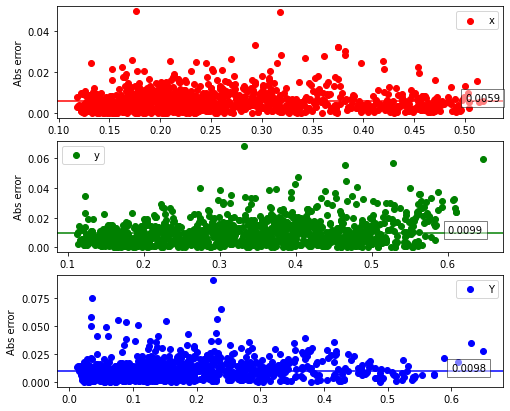

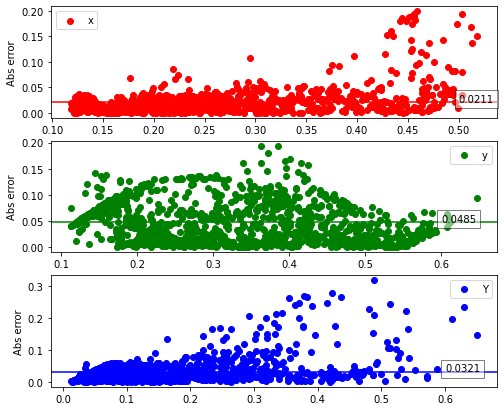

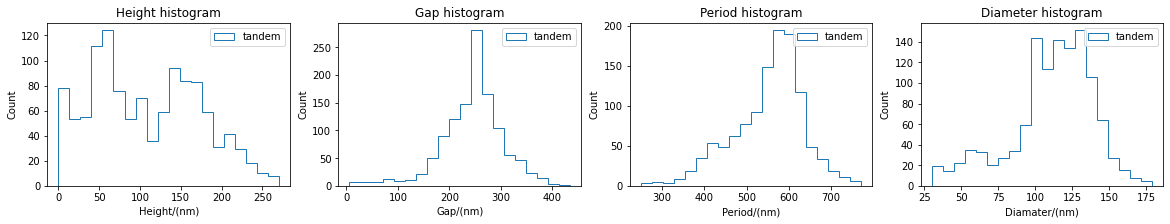

In [19]:
# Plot Absolute Error

# target - forward 
plt_abs_err(CIE_x, cie_pred)

# target - RCWA
plt_abs_err(CIE_x, xyY_pred)
# plot structure distribution
plt_hist_all(param_pred, 'tandem')

1173


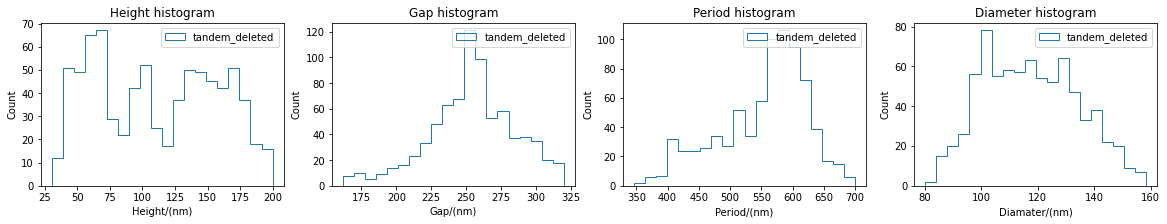

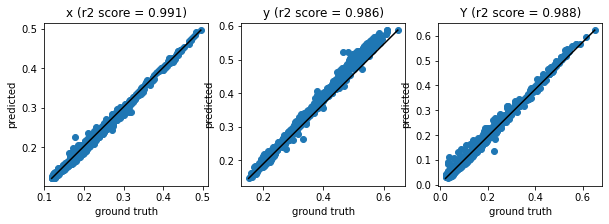

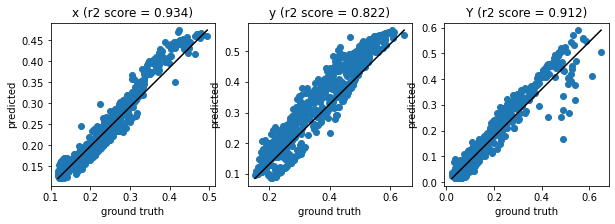

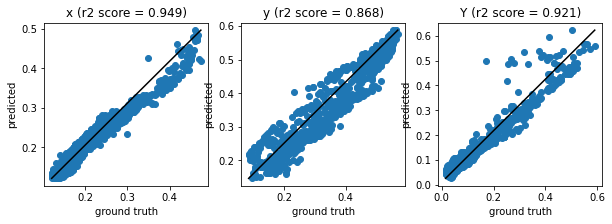

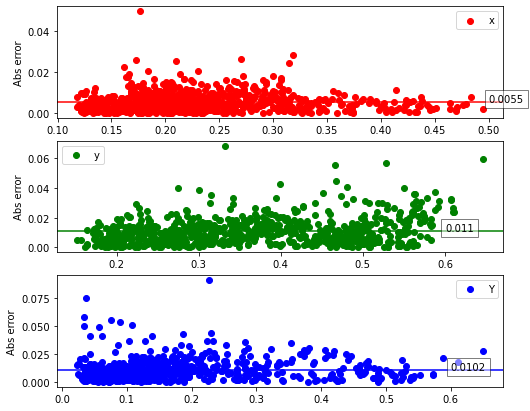

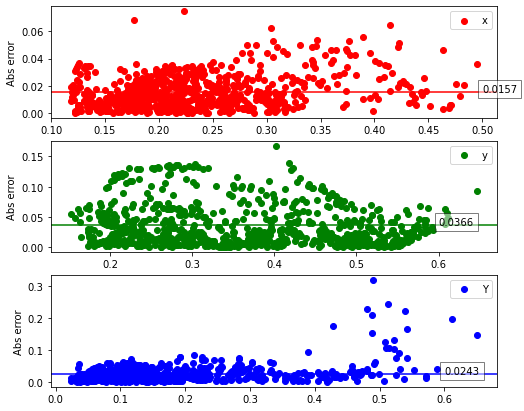

In [20]:
# Plot the result(also delete structures that not inside the range of test structures)


B = struc_remove_2(param_pred)

param_pred_deleted = np.delete(param_pred, B, axis=0)
CIE_x_deleted = np.delete(CIE_x, B, axis=0)
cie_pred_deleted = np.delete(cie_pred, B, axis=0)
xyY_pred_deleted = np.delete(xyY_pred, B, axis=0)

plt_hist_all(param_pred_deleted, 'tandem_deleted')



# Evaluation 1: comparing the CIE target VS forward
plot_cie_raw_pred(CIE_x_deleted, cie_pred_deleted)

# Evaluation 2：comparing the CIE target VS RCWA
plot_cie_raw_pred(CIE_x_deleted, xyY_pred_deleted)

# Evaluation 3: comparing the CIE forward VS RCWA
plot_cie_raw_pred(xyY_pred_deleted, cie_pred_deleted)# target - forward 



plt_abs_err(CIE_x_deleted, cie_pred_deleted)

# target - RCWA
plt_abs_err(CIE_x_deleted, xyY_pred_deleted)


In [31]:
np.shape(xyY_pred_deleted)

(776, 3)

# Use another forward model to evaluate the predictred structure

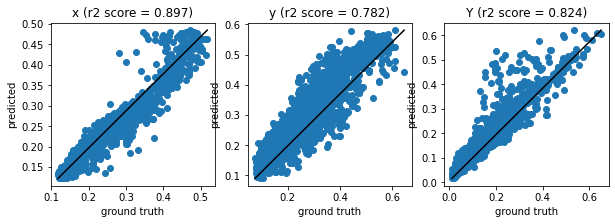

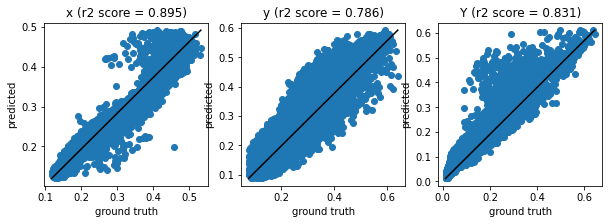

In [6]:
# the prediction ability pf another forward model
forward_model = MLP(4, 3).to(DEVICE)
inverse_model = MLP(3, 4).to(DEVICE)

tandem_model = TandemNet(forward_model, inverse_model)
tandem_model.load_state_dict(torch.load('./models/tandem_net_trained.pth')['model_state_dict'])



forward_model = MLP(4, 3).to(DEVICE)
forward_model = tandem_model.forward_model
#forward_model.load_state_dict(torch.load('./models/forward_model_trained_training.pth')['model_state_dict'])

cie_pred, cie_raw = evaluate_forward(forward_model, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


cie_pred, cie_raw = evaluate_forward(forward_model, train_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

Tandem net Design RMSE loss 0.787
Tandem Design RMSE loss 165.566
Reconstruct RMSE loss 0.481
Reconstruct RMSE loss raw 0.231
Tandem net Design RMSE loss 0.787
Tandem Design RMSE loss 165.566
Reconstruct RMSE loss 0.037
Reconstruct RMSE loss raw 0.020


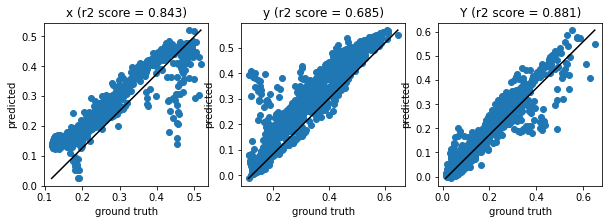

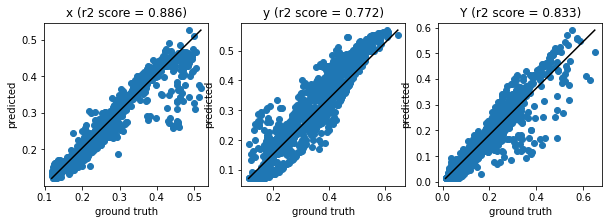

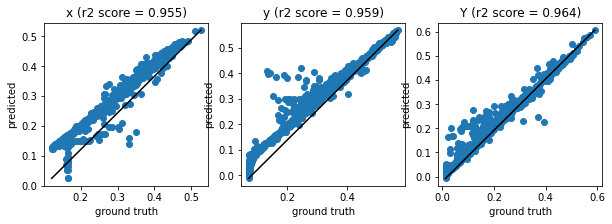

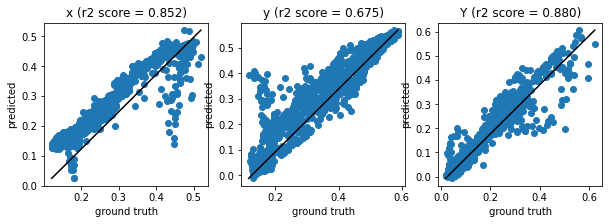

In [34]:
# Evaluate prediction of tandem model using another forward model

forward_model = MLP(4, 3).to(DEVICE)
inverse_model = MLP(3, 4).to(DEVICE)

tandem_model = TandemNet(forward_model, inverse_model)
tandem_model.load_state_dict(torch.load('./models/tandem_net_trained_old.pth')['model_state_dict'])


forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained_evaluate_2.pth')['model_state_dict'])
#forward_model = tandem_model.forward_model

cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_minmax_newforward_accuracy(tandem_model, test_loader.dataset, forward_model)
#cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_minmax_accuracy(tandem_model, train_loader.dataset)

cie_raw1, param_raw11, cie_pred1, param_pred1 = evaluate_tandem_minmax_newforward_accuracy(tandem_model, test_loader.dataset, tandem_model.forward_model)



# Plot the result(only delete structures that not satisfy the limitation of structures)

filepath ="data_predicted/xyY/xyY_param_tandem_pred_old.mat"
filepath3 = "data_predicted/param_tandem_pred_old.mat"

temp = scipy.io.loadmat(filepath)
xyY_pred = np.array(list(temp.items())[7][1])  # predicted by RCWA

temp = scipy.io.loadmat(filepath3)
delete_row = np.array(list(temp.items())[7][1])

CIE_x = np.delete(cie_raw, delete_row, axis=0)    # target 
cie_pred = np.delete(cie_pred, delete_row, axis=0) # predicted by forward model
param_raw = np.delete(param_raw, delete_row, axis=0)
param_pred = np.delete(param_pred, delete_row, axis=0)

# Evaluation 1: comparing the CIE target VS forward
plot_cie_raw_pred(CIE_x, cie_pred)

# Evaluation 2：comparing the CIE target VS RCWA
plot_cie_raw_pred(CIE_x, xyY_pred)

# Evaluation 3: comparing the CIE forward VS RCWA
plot_cie_raw_pred(xyY_pred, cie_pred)

# evaluate 4: compare the two model's prediction on predicted results
cie_pred1 = np.delete(cie_pred1, delete_row, axis=0)
plot_cie_raw_pred(cie_pred1, cie_pred)

In [18]:
torch.save({
    'epoch': 200,
    'model_state_dict': forward_model.state_dict(),
    'loss': 0,
     }, './models/forward_model_trained.pth')